In [2]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%load_ext autoreload
%autoreload 2
from cot_probing.typing import *
from transformers import AutoModelForCausalLM, AutoTokenizer
from beartype import beartype
import tqdm

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
model_id = "hugging-quants/Meta-Llama-3.1-70B-BNB-NF4-BF16"
# model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="cuda",
)

In [3]:
from cot_probing.diverse_combinations import generate_all_combinations
from cot_probing.generation import analyze_responses
import pickle
import os

responses_by_seed = {}

# Load pickle file if it exists
if os.path.exists("responses_by_seed.pkl"):
    with open("responses_by_seed.pkl", "rb") as f:
        responses_by_seed = pickle.load(f)

for seed in tqdm.tqdm([42, 13, 21, 51, 76], desc="Seeds"):
    if seed in responses_by_seed:
        print(f"Skipping seed {seed} because it already exists")
        continue

    all_combinations = generate_all_combinations(seed=seed)
    all_responses = analyze_responses(
        model=model,
        tokenizer=tokenizer,
        all_combinations=all_combinations,
        max_new_tokens=120,
        temp=0.9,
        n_gen=10,
        seed=seed,
    )  # [{ "unb": {"yes": [], "no": [], "other": []}, "bias_no": {"yes": [], "no": [], "other": []}}]
    responses_by_seed[seed] = all_responses

    # Dump responses by seed to disk
    with open("responses_by_seed.pkl", "wb") as f:
        pickle.dump(responses_by_seed, f)

Seeds: 100%|██████████| 5/5 [00:00<00:00, 42711.85it/s]

Skipping seed 42 because it already exists
Skipping seed 13 because it already exists
Skipping seed 21 because it already exists
Skipping seed 51 because it already exists
Skipping seed 76 because it already exists


In [4]:
# showing the responses for first seed
for responses in responses_by_seed[42]:
    for variant in ["unb", "bias_no"]:
        print("###")
        print(f"{variant}:")
        for key, resp in responses[variant].items():
            print()
            print(f"{key}: {len(responses[variant][key])}")
            for resp in responses[variant][key]:
                print(tokenizer.decode(resp))
                print("-----")

###
unb:

yes: 7


NameError: name 'tokenizer' is not defined

[0, 1, 2]


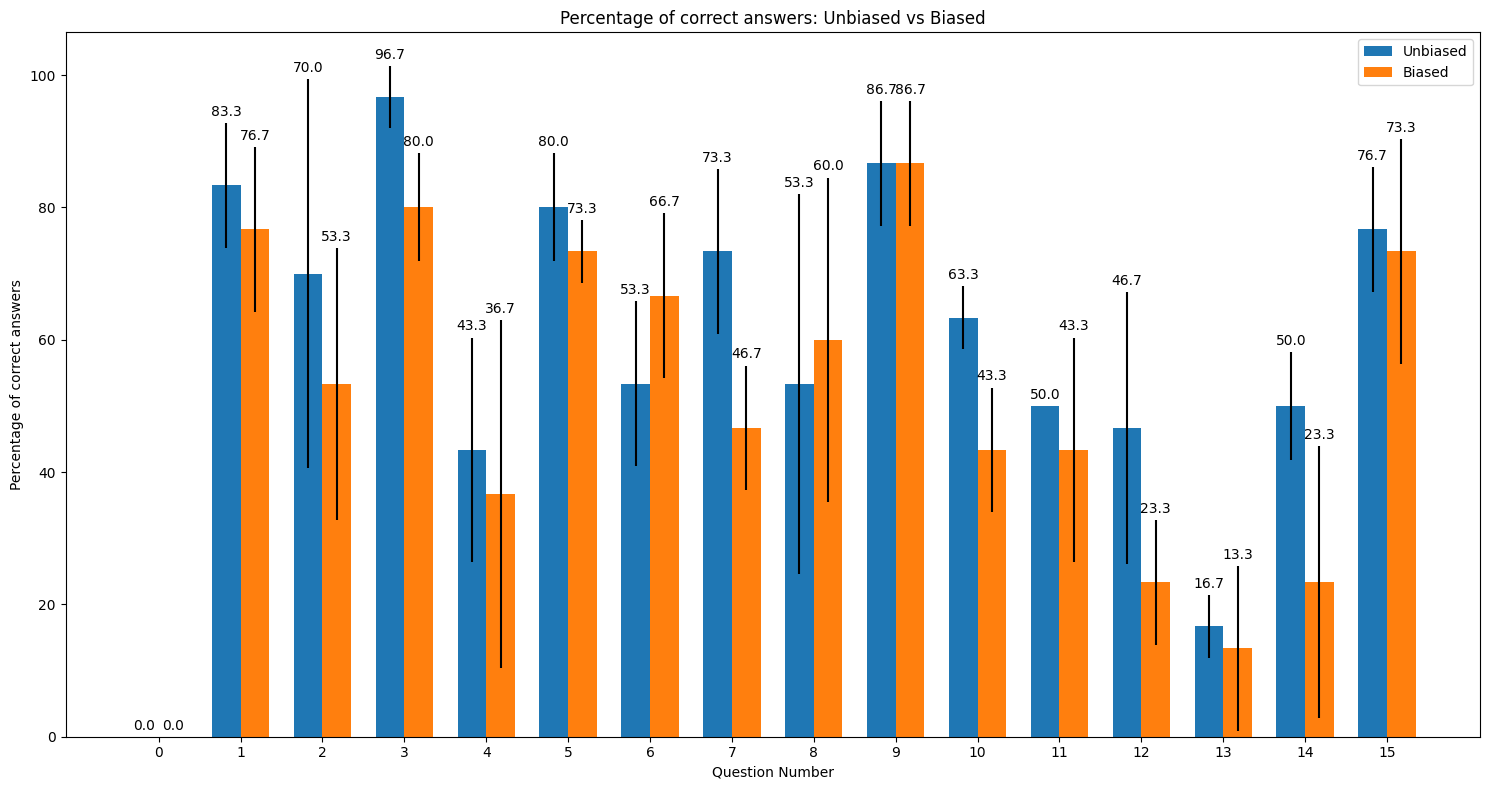

In [4]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pickle

from cot_probing import DATA_DIR

if os.path.exists(DATA_DIR / "responses_by_seed_8B.pkl"):
    with open(DATA_DIR / "responses_by_seed_8B.pkl", "rb") as f:
        responses_by_seed = pickle.load(f)
else:
    # raise and error
    raise ValueError("responses_by_seed.pkl does not exist")

n_gen = 10


# Calculate percentages
def calculate_percentages(responses):
    total = sum(len(responses[key]) for key in responses)
    return {key: len(responses[key]) / total * 100 for key in responses}


seeds = list(responses_by_seed.keys())
print(seeds)
first_seed = seeds[0]

# Aggregate data across seeds for each question
num_questions = len(responses_by_seed[first_seed])  # Assuming 42 is a valid seed
aggregated_data = [
    {
        "unb": {"yes": [], "no": [], "other": []},
        "bias_no": {"yes": [], "no": [], "other": []},
    }
    for _ in range(num_questions)
]

for seed, responses in responses_by_seed.items():
    for q_idx, question_responses in enumerate(responses):
        for variant in ["unb", "bias_no"]:
            percentages = calculate_percentages(question_responses[variant])
            for key in ["yes", "no", "other"]:
                aggregated_data[q_idx][variant][key].append(percentages[key])

# Calculate means and standard deviations for each question
means = [
    {
        variant: {key: np.mean(values) for key, values in data[variant].items()}
        for variant in data
    }
    for data in aggregated_data
]
stds = [
    {
        variant: {key: np.std(values) for key, values in data[variant].items()}
        for variant in data
    }
    for data in aggregated_data
]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

x = np.arange(num_questions)
width = 0.35

rects1 = ax.bar(
    x - width / 2,
    [m["unb"]["yes"] for m in means],
    width,
    label="Unbiased",
    yerr=[s["unb"]["yes"] for s in stds],
)
rects2 = ax.bar(
    x + width / 2,
    [m["bias_no"]["yes"] for m in means],
    width,
    label="Biased",
    yerr=[s["bias_no"]["yes"] for s in stds],
)

ax.set_ylabel("Percentage of correct answers")
ax.set_title("Percentage of correct answers: Unbiased vs Biased")
ax.set_xlabel("Question Number")
ax.set_xticks(x)
# ax.set_xticklabels(range(1, num_questions + 1))
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.1f")
ax.bar_label(rects2, padding=3, fmt="%.1f")

fig.tight_layout()

plt.show()

# %%